# Reversal Pairs Trading Strategy

The **reversal pairs trading strategy** is a trading approach that seeks to profit from short-term price divergences between two historically correlated assets. It is built on the principle of **mean reversion**, which assumes that the relative price of two assets tends to return to its historical equilibrium over time.
- Two assets with a strong historical relationship (e.g., highly correlated or cointegrated) should move together. 
- When their prices temporarily diverge, it creates an opportunity:  
  - **Overvalued asset** is expected to fall back.  
  - **Undervalued asset** is expected to rise back.  
- The strategy profits when the spread between the two assets **reverses back to normal**
   - When the spread deviates significantly (e.g., 2 standard deviations) from its mean:  
     - **Go long** the undervalued asset and **short** the overvalued asset.  
   - Exit the trade when the spread mean-reverts.
- The long and short positions balance each other, reducing exposure to overall market direction.

#### Why It Works
- Short-term mispricings often occur due to noise, liquidity shocks, or temporary market inefficiencies.  
- Long-term fundamentals and arbitrage pressure drive prices back to equilibrium.  
- By betting on **reversal to the mean**, the strategy exploits these inefficiencies.  

**In summary:**  
The reversal pairs trading strategy systematically identifies temporary price divergences between two related assets, takes offsetting long/short positions, and profits when prices revert back to their historical relationship.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from time import time
from typing import Dict, Optional

## Data Loading and Preparation

We first load daily price data OHLCV and clean it.

In [2]:
df = pd.read_pickle('../data/binance_1D_crypto_data.pkl')
df = df[df['open_time'].dt.date != df['open_time'].dt.date.max()]

print("Shape before {}".format(df.shape))
print("Number of duplicated rows is {}".format(df.duplicated().sum()))

df = df.drop_duplicates(keep='first')
print("Shape after {}".format(df.shape))

df.head()

Shape before (158568, 7)
Number of duplicated rows is 0
Shape after (158568, 7)


,open_time,open,high,low,close,volume,symbol
0,2024-06-17,0.09500000,0.29500000,0.09500000,0.21300000,1558854668.40000000,ZKUSDT
1,2024-06-18,0.21300000,0.23200000,0.18600000,0.22020000,1189119720.30000000,ZKUSDT
2,2024-06-19,0.22020000,0.24000000,0.21260000,0.22420000,727374424.10000000,ZKUSDT
3,2024-06-20,0.22420000,0.22420000,0.19100000,0.19830000,493478200.90000000,ZKUSDT
4,2024-06-21,0.19830000,0.20360000,0.17600000,0.18220000,382766488.90000000,ZKUSDT


In [3]:
def pivot_reindexed_data(df, value):
    new_df = df.pivot(values = value, columns = 'symbol', index = 'open_time')
    new_df = pd.DataFrame(new_df).astype(float)
    new_df = new_df.reindex(pd.date_range(new_df.index[0],new_df.index[-1],freq='1d'))
    return new_df

px = pivot_reindexed_data(df,'close').loc[:'2025-08']
print(f"Price data dimensions before {px.shape}")
# Omitting tickers with less than 90% of non null values.
px = px.loc[:,(px.notna().sum()/(px.shape[0]))>= 0.95]
print(f"Price data dimensions after {px.shape}")

vols = pivot_reindexed_data(df,'volume').loc[:'2025-08']
vols = vols[px.columns]

insample_start = pd.Timestamp("2022-01-01")
insample_end = pd.Timestamp("2023-12-31")

outsample_start = pd.Timestamp("2024-01-01")

# Training set
px_train = px.loc[:insample_end]
vols_train = px.loc[:insample_end]

Price data dimensions before (1704, 132)
Price data dimensions after (1704, 59)


In [4]:
px.tail()

symbol,1INCHUSDT,AAVEUSDT,ADAUSDT,ALGOUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,BNBUSDT,BTCUSDT,...,TFUELUSDT,THETAUSDT,TRXUSDT,TWTUSDT,UNIUSDT,VETUSDT,XLMUSDT,XRPUSDT,XTZUSDT,ZECUSDT
2025-08-27,0.2496,320.63,0.8509,0.2475,4.491,24.42,2.304,550.2,855.18,111262.01,...,0.03468,0.790,0.3451,0.7581,9.854,0.02487,0.3790,2.9688,0.7872,42.27
2025-08-28,0.2538,317.56,0.8576,0.2528,4.782,24.93,2.397,557.9,873.47,112566.90,...,0.03569,0.828,0.3451,0.7541,10.018,0.02561,0.3822,2.9665,0.7842,42.47
2025-08-29,0.2444,319.20,0.8266,0.2365,4.483,23.55,2.251,530.7,862.30,108377.40,...,0.03410,0.779,0.3385,0.7352,9.633,0.02425,0.3614,2.8195,0.7335,40.21
2025-08-30,0.2469,319.39,0.8224,0.2337,4.505,23.78,2.292,552.8,862.00,108816.33,...,0.03462,0.784,0.3390,0.7383,9.726,0.02471,0.3600,2.8181,0.7369,40.05
2025-08-31,0.2421,315.69,0.8113,0.2316,4.467,23.40,2.522,544.2,857.65,108246.35,...,0.03448,0.781,0.3410,0.7368,9.619,0.02414,0.3528,2.7757,0.7199,40.43


In [5]:
def drawdown(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    return drawdown

In [6]:
def duration(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    if isinstance(returns, pd.DataFrame):
        ddd = pd.DataFrame(index = returns.index, columns = returns.columns)
        for col in returns.columns:
            ddd[col] = duration[col].groupby((duration[col] != duration[col].shift()).cumsum()).cumsum()
    else:
        ddd = duration.groupby((duration != duration.shift()).cumsum()).cumsum()
    return ddd

In [7]:
def calculate_metrics(returns, benchmark:Optional = False):
    """
    Compute total return, annualized return/vol, Sharpe, max drawdown, win rate.
    """
    
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    max_duration = duration.groupby((duration != duration.shift()).cumsum()).cumsum().max()

    cum_ret = cumulative.iloc[-1] - 1
    ann_vol = returns.std() * np.sqrt(365)
    ann_ret = returns.mean() * 365
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    max_dd = drawdown.min()

    # consider only non-zero returns as individual trades
    trade_rets = returns[returns != 0]
    win_rate   = (trade_rets > 0).sum() / len(trade_rets)
    
    metrics = pd.Series({
        "Cumulative Return": f"{(cum_ret * 100):.2f}%",
        "Annualized Return": f"{(ann_ret * 100):.2f}%",
        "Annualized Volatility": f"{(ann_vol * 100):.2f}%",
        "Sharpe Ratio": sharpe,
        "Max Drawdown": f"{(max_dd * 100):.2f}%",
        "Max Drawdown Duration": f"{(max_duration):.2f} days",
        "Win Rate": f"{(win_rate * 100):.2f}%"
    })
    
    if benchmark:
        bench_rets = px['BTCUSDT'].ffill().pct_change().loc[returns.index]
        X = sm.add_constant(bench_rets)
        y = returns
        model = sm.OLS(y, X).fit()
        alpha = model.params['const']
        beta  = model.params['BTCUSDT']
        active_rets = returns - beta * bench_rets
        IR = active_rets.mean() / active_rets.std() * np.sqrt(365)
    
        metrics["Info Ratio"] = IR
    else: metrics["Info Ratio"] = 'N/A'

    return metrics

In [8]:
def backtest_with_costs(prices, port, tcost_bps = 20):
    ret = prices.ffill().pct_change()
    gross_ret = (port.shift() * ret).sum(axis=1)

    # Turnover
    turnover = (port.fillna(0) - port.shift().fillna(0)).abs().sum(axis=1)

    # Cost in return units
    cost = turnover * (tcost_bps * 1e-4)
    net_ret = gross_ret - cost

    return net_ret, gross_ret, turnover

Below **top_pairs_corr_coint** function:
- Computes log-prices and log-returns, then define rebalance dates every 90 days window.  
- For each rebalance date,it calculates a rolling correlation matrix of returns over the past ~182 days(half year).  
- Selects candidate pairs with correlation above `corr_threshold`.  
- Tests cointegration of each candidate pair; keep pairs with p-value below `pvalue_threshold`.  
- Returns the top `max_pairs` cointegrated pairs sorted by correlation for each rebalance date.

In [9]:
def top_pairs_corr_coint(prices, window=90, corr_threshold=0.82, pvalue_threshold=0.1, max_pairs=40):    
    logp = np.log(prices.ffill())
    log_rets = logp.diff()
    reb_dates = log_rets.index[window::window]

    schedule = []

    for date in reb_dates:
        block_idx = log_rets.index.get_loc(date)
        if date - pd.Timedelta(days = 182) > pd.Timestamp('2021-01-01'):
            block = log_rets.iloc[block_idx+1-182:block_idx+1]
        else:
            block = log_rets.iloc[:block_idx+1]
        corr_mat = block.corr(min_periods = 30)

        # 1) finding correlated candidates
        candidates = []
        cols = corr_mat.columns
        for i, a in enumerate(cols):
            for b in cols[i+1:]:
                ρ = corr_mat.at[a,b]
                if pd.isna(ρ) or abs(ρ) < corr_threshold:
                    continue

                # 2) testing cointegration on log-prices over the SAME block
                y = logp[a].loc[block.index]
                x = logp[b].loc[block.index]
                
                if y.isna().any() == True or x.isna().any() == True:
                    n,m = y.isna().sum(), x.isna().sum()
                    if n > m:
                        y, x = y[n:], x[n:]
                    else:
                        y, x = y[m:], x[m:]
                score, pval, _ = coint(y, x)
                if pval < pvalue_threshold:
                    candidates.append((a, b, ρ, pval)) 
                    
        # 3) sorting by |corr| (or p-value) and limit
        candidates.sort(key=lambda tup: abs(tup[2]), reverse=True)
        top = candidates[:max_pairs]
        pairs = [(a,b) for a,b,_,_ in top]
        schedule.append((date, pairs, len(pairs)))

    return pd.DataFrame(schedule, columns=['reb_date','trading_pairs', 'pairs_count'])

## Trading Strategy: Reversal/Mean-Reversion

#### 1. Compute Beta and Spread
For each cointegrated pair \((x, y)\), compute rolling beta and spread:

$$
\beta_t = \frac{\text{Cov}(logr_x, logr_y)}{\text{Var}(logr_x)} \approx \text{corr}(logr_x, logr_y) \cdot \frac{\sigma_y}{\sigma_x}
$$

$$
\text{spread}_t = logr_y - \beta_t \cdot logr_x
$$

- $(logr_x, logr_y)$ are log-returns.  
- Spread measures deviation from the long-term linear relationship.

---
#### 2. Z-Score Calculation
Standardize the spread over a 90 days rolling window:
$$
z_t = \frac{\text{spread}_t - \mu_{\text{spread},t}}{\sigma_{\text{spread},t}}
$$

- Mean ($(\mu$)) and std ($(\sigma$)) are computed over the past 90 days.  
- Z-score identifies extreme deviations for trading signals.

---
#### 3. Generate Portfolio Positions
- **Entry Rules:**  
$$
\begin{cases}
z_t > z_{\text{entry}} \implies \text{short spread: } y=-1, x=+\beta_t\\
z_t < -z_{\text{entry}} \implies \text{long spread: } y=+1, x=-\beta_t
\end{cases}
$$

- **Exit Rule:**  
$$
|z_t| < z_{\text{exit}} \implies \text{flat positions } (0)
$$

- Positions from overlapping pairs are summed, normalized, and squashed with $(\tanh$) for stability.

---
#### 4. Optimization
- Entry threshold is set as $(z_{\text{entry}}$) a variable that depends on ratio of short term and long term volatility of the spread. Sweep exit thresholds $(z_{\text{exit}}$) between [0,1] to find the best trade-off between return, risk, and turnover.  
- Strategy adapts dynamically: pairs rebalance periodically and positions update based on rolling z-scores.


In [10]:
def compute_signals(log_rets, pairs, window = 90, start = px.index[0]):
    """
    Given returns `log_rets` and a list of pairs, compute three DataFrames:
      - beta[(x,y)]_t
      - spread[(x,y)]_t = log_rets_y - beta_t * log_rets_x
      - zscore[(x,y)]_t = (spread - mean)/std over rolling window
    All indexed by log_rets.index.
    """
    betas, spreads, zscores, vol_ind = {}, {}, {}, {}
    for x,y in pairs:
        vol_x = log_rets[x].rolling(window).std()
        vol_y = log_rets[y].rolling(window).std()
        corr  = log_rets[x].rolling(window).corr(log_rets[y])
        β     = corr * vol_y / vol_x
        s     = log_rets[y] - β * log_rets[x]
        m     = s.rolling(window, min_periods = 1).mean()
        sd    = s.rolling(window, min_periods = 1).std()
        z     = (s - m) / sd

        betas[(x,y)]  = β
        spreads[(x,y)] = s
        zscores[(x,y)] = z
        vol_ind[(x,y)] = sd / s.rolling(180, min_periods = 1).std()

    beta_df   = pd.DataFrame(betas).loc[start:]
    spread_df = pd.DataFrame(spreads).loc[start:]
    z_df      = pd.DataFrame(zscores).loc[start:]
    vol_ind   = pd.DataFrame(vol_ind).loc[start:]
    return beta_df, spread_df, z_df, vol_ind

In [11]:
def generate_portfolio(zscores, beta, factor, entry = 1.0, exit_z = 0.5):
    """
    Build a portfolio DataFrame indexed by zscores.index, columns=assets,
    where for each pair (x,y):
      - if z > entry_z:  pos[y] = -1, pos[x] = +beta
      - if z < -entry_z: pos[y] = +1, pos[x] = -beta
      - if |z| < exit_z: pos[y], pos[x] = 0
    Positions from overlapping pairs are summed.
    """
    # initialize flat portfolio
    assets = sorted({asset for pair in zscores.columns for asset in pair})
    portfolio = pd.DataFrame(index=zscores.index, columns=assets)

    # loop over each pair (columns in zscores are MultiIndex or tuples)
    for (x, y) in zscores.columns:
        z = zscores[(x, y)]
        β = beta[(x, y)]
        c = factor[(x, y)]
        entry_z = 1/(1+np.exp(-entry * c)) + 1 # entry_z depends on spread - short vs longterm volatility. 
        
        # long spread when z < -entry_z
        long_mask  = z < -entry_z
        portfolio.loc[long_mask,  y] +=  1.0
        portfolio.loc[long_mask,  x] += -β.loc[long_mask]

        # short spread when z > entry_z
        short_mask = z >  entry_z
        portfolio.loc[short_mask, y] += -1.0
        portfolio.loc[short_mask, x] +=  β.loc[short_mask]

        # exit when |z| < exit_z: zero out those dates
        exit_mask = z.abs() < exit_z
        portfolio.loc[exit_mask, [x, y]] = 0.0
    portfolio = portfolio.ffill()

    return portfolio

In [12]:
def optimize_thresholds(prices, schedule, entry=1.0, exit_z_list=None, window=90 , trade_start = insample_start):
    log_rets = np.log(prices.ffill()).diff()
    rets = prices.ffill().pct_change()
    
    if exit_z_list is None:
        exit_z_list = np.linspace(0.1, 1.0, 19)
        
    schedule = schedule.set_index('reb_date')[:prices.index.max()].reset_index()

    results = []
    for exit_z in exit_z_list:
        # fresh zero‐port
        port = pd.DataFrame(index=log_rets.index, columns=log_rets.columns)

        # loop over each non‐overlapping block
        for i, (reb_date, pairs, _) in schedule.iterrows():
            loc = log_rets.index.get_loc(reb_date)
            if loc + 1 >= len(log_rets):
                break
            start = log_rets.index[loc + 1]

            if i < len(schedule)-1:
                end = schedule['reb_date'].iloc[i+1]
            else:
                end = log_rets.index[-1]

            block = log_rets.loc[:end]
            beta_df, spread_df, z_df, factor = compute_signals(block, pairs, window=window, start = start)
            
            block_port = generate_portfolio(z_df, beta_df, factor, entry, exit_z)
            
            port.loc[start:end, block_port.columns] = block_port.fillna(0)
            

        port = port.ffill()
        port = port.loc[trade_start:]
        port = np.tanh(port)
        port = port.ewm(span = 10, adjust = False).mean()
        
        port[(port > 0).rolling(65).sum() >= 60] = 0
        port[(port < 0).rolling(40).sum() >= 35] = 0
        
        port = port.divide(port.abs().sum(1),0).fillna(0)

        # backtest
        net_ret, gross_ret, turnover = backtest_with_costs(prices.loc[trade_start:], port)
        to = turnover.mean()
        
        cum = (1 + net_ret).cumprod()
        total = cum.iloc[-1] - 1
        ann_ret = net_ret.mean() * 365
        ann_vol = net_ret.std() * np.sqrt(365)
        sharpe  = ann_ret / ann_vol if ann_vol>0 else np.nan
        drawd   = (cum / cum.cummax() - 1)
        max_dd = drawd.min()
        duration = (drawd != 0).astype(int)
        max_dur = duration.groupby((duration != duration.shift()).cumsum()).cumsum().max()
        trade_rets = net_ret[net_ret != 0]
        win_rate   = (trade_rets > 0).sum() / len(trade_rets)
        info_IR = calculate_metrics(net_ret, True)['Info Ratio']
        results.append({
            'exit_z': exit_z,
            'Total Return': f"{(total * 100):.2f}%",
            'Ann. Return': f"{(ann_ret * 100):.2f}%",
            'Ann. Vol': f"{(ann_vol * 100):.2f}%",
            'Sharpe': sharpe,
            'Info_IR': info_IR,
            'Max Drawdown': f"{(max_dd * 100):.2f}%",
            'Max DD Duration': f"{(max_dur):.2f} days",
            'Win Rate': f"{(win_rate * 100):.2f}%",
            'Turnover': f"{to:.2f}"
        })

    return pd.DataFrame(results).set_index('exit_z')

In [13]:
schedule = top_pairs_corr_coint(px_train, 
                                window = 90, 
                                corr_threshold = 0.82, 
                                pvalue_threshold=0.1,
                                max_pairs = 40)

df_exit = optimize_thresholds(px_train, schedule,
    entry=0.5,
    exit_z_list = np.linspace(0.1, 1.0, 10),
    window=90,
    trade_start = insample_start)

df_exit.sort_values(by = 'Sharpe', ascending = False)

,Total Return,Ann. Return,Ann. Vol,Sharpe,Info_IR,Max Drawdown,Max DD Duration,Win Rate,Turnover
exit_z,,,,,,,,,
0.6,168.87%,57.85%,41.03%,1.409705,1.399640,-40.75%,186.00 days,53.59%,0.14
0.7,129.11%,49.41%,39.93%,1.237304,1.222440,-41.78%,202.00 days,53.68%,0.15
0.9,84.96%,37.68%,37.30%,1.010209,0.991271,-44.27%,317.00 days,51.64%,0.15
0.5,79.49%,37.47%,40.56%,0.923783,0.903081,-37.98%,266.00 days,52.78%,0.15
1.0,74.40%,36.13%,40.72%,0.887230,0.867691,-45.30%,368.00 days,53.24%,0.15
0.8,68.60%,33.59%,38.65%,0.868908,0.848570,-45.04%,317.00 days,51.58%,0.15
0.4,44.01%,26.46%,40.65%,0.650949,0.627217,-39.67%,260.00 days,49.58%,0.13
0.3,-23.27%,-5.36%,39.65%,-0.135280,-0.185626,-54.08%,510.00 days,46.79%,0.12
0.2,-41.11%,-18.03%,40.97%,-0.440168,-0.475360,-57.06%,508.00 days,47.51%,0.10


## Walk Forward Validation

In [14]:
# WALK FORWARD VALIDATION SPLITS
splits = [
    ("2021-01", "2021-12", "2022-01", "2022-06"),
    ("2021-01", "2022-06", "2022-07", "2022-12"),
    ("2021-01", "2022-12", "2023-01", "2023-06"),
    ("2021-01", "2023-06", "2023-07", "2023-12")]

In [15]:
entries = np.arange(0.5,2,0.5) 

results = pd.DataFrame()

for split_id, (_, _, val_start, val_end) in enumerate(splits, 1):
    begin = time()
    for entry in entries:
        m = optimize_thresholds(px_train[:val_end], schedule,
                            entry = entry,
                            exit_z_list = np.linspace(0.1, 1.0, 10),
                            window = 90,
                            trade_start = val_start)
        m = m.reset_index()
        m.insert(0, 'entry', entry)
        m.insert(0, 'split', split_id) 
        results = pd.concat([results, m])
    end = time()
    print(split_id," ",end-begin, " seconds")
    
cv_results = results

# Average validation performance
avg_scores = cv_results.groupby(["entry", "exit_z"])["Sharpe"].mean().reset_index()
best_params = avg_scores.loc[avg_scores["Sharpe"].idxmax()]

print("Average validation scores (top 5):")
print(avg_scores.sort_values("Sharpe", ascending=False).head())

1   2.823706865310669  seconds
2   6.175471782684326  seconds
3   7.039796829223633  seconds
4   7.551709890365601  seconds
Average validation scores (top 5):
   entry  exit_z    Sharpe
8    0.5     0.9  0.615585
9    0.5     1.0  0.533816
5    0.5     0.6  0.528313
7    0.5     0.8  0.415951
6    0.5     0.7  0.353247


In [16]:
agg = cv_results.groupby(["entry", "exit_z"])["Sharpe"].agg(["mean","std"]).reset_index()

# penalize volatility
agg["robust_score"] = (agg["mean"] - agg["mean"].mean())/agg["mean"].std() \
                    - (agg["std"] - agg["std"].mean())/agg["std"].std()

agg = agg.set_index(['entry','exit_z'])

best_5 = avg_scores.sort_values("Sharpe", ascending=False)[:5]\
            .set_index(['entry','exit_z'])

top5_score = agg.join(best_5, how = 'right').reset_index()

# agg["robust_score"] = agg["mean"] - agg["std"]
top5_score.sort_values(by = 'robust_score', ascending = False)

,entry,exit_z,mean,std,robust_score,Sharpe
1,0.5,1.0,0.533816,3.052040,0.119727,0.533816
2,0.5,0.6,0.528313,3.069967,0.093611,0.528313
4,0.5,0.7,0.353247,2.986231,-0.032594,0.353247
0,0.5,0.9,0.615585,3.622779,-0.394065,0.615585
3,0.5,0.8,0.415951,3.454258,-0.459298,0.415951


robust score indicator suggest [0.5, 1.0] has the best parameter set

<!-- ### Exit Threshold Sensitivity Analysis
**Optimal Exit Thresholds (0.4–0.6):**  
- Gives the best trade-off between return, risk, and turnover.  
- Example: exit_z=0.4 → Total Return: 253%, Sharpe: 1.51, Max Drawdown: -29.6%, Turnover: 0.41 

**High Exit Thresholds (0.8–1.0):**  
- Have higher returns, but **Sharpe decreases** and drawdowns increase significantly.  
- Turnover rises due to longer-held trades.  

**Low Exit Thresholds (0.1–0.3):**  
- Have very low returns and Sharpe ratios, but slightly reduced drawdowns.  
- Overly conservative, strategy fails to capture profitable moves. 

We choose an **exit threshold of 0.6** because it strikes a balance between capturing profits and limiting risk.  
- With **entry_z = 1**, exiting when |z| < 0.6 means we close trades **once the spread starts reverting**, securing gains early and avoiding trades that may fail to fully revert.  
- Lower exit thresholds (e.g., 0.1–0.3) would hold trades much longer, potentially increasing profits but also exposing the strategy to **large losses if the spread never fully reverts**.  
- Higher exit thresholds (closer to entry_z) would exit too quickly, missing most of the mean-reversion move.   

Thus **0.6 offers a robust compromise**: profitable, controlled drawdowns, and reasonable turnover. -->

In [17]:
entries = np.arange(0.5,2,0.5) 

results = pd.DataFrame()

for split_id, (_, _, val_start, val_end) in enumerate(splits, 1):
    begin = time()
    for entry in entries:
        m = optimize_thresholds(px_train[:val_end], schedule,
                            entry = entry,
                            exit_z_list = np.linspace(0.1, 1.0, 10),
                            window = 90,
                            trade_start = val_start)
        m = m.reset_index()
        m.insert(0, 'entry', entry)
        m.insert(0, 'split', split_id) 
        results = pd.concat([results, m])
    end = time()
    print(split_id," ",end-begin, " seconds")
    
cv_results = results

# Average validation performance
avg_scores = cv_results.groupby(["entry", "exit_z"])["Info_IR"].mean().reset_index()
best_params = avg_scores.loc[avg_scores["Info_IR"].idxmax()]

print("Average validation scores (top 5):")
print(avg_scores.sort_values("Info_IR", ascending=False).head())
print("\nBest parameter pair:", dict(best_params))

1   2.783092975616455  seconds
2   6.059406042098999  seconds
3   7.120995998382568  seconds
4   7.5605199337005615  seconds
Average validation scores (top 5):
   entry  exit_z   Info_IR
9    0.5     1.0  0.473997
8    0.5     0.9  0.455340
5    0.5     0.6  0.364767
7    0.5     0.8  0.292180
6    0.5     0.7  0.226627

Best parameter pair: {'entry': 0.5, 'exit_z': 1.0, 'Info_IR': 0.47399717704120714}


[0.5, 1.0] is still winning when it comes to information ratio

In [18]:
schedule

,reb_date,trading_pairs,pairs_count
0,2021-04-01,[],0
1,2021-06-30,"[(BNBUSDT, CAKEUSDT), (LINKUSDT, XTZUSDT)]",2
2,2021-09-28,"[(JSTUSDT, TRXUSDT), (BNBUSDT, CAKEUSDT), (BCH...",17
3,2021-12-27,"[(LINKUSDT, VETUSDT), (ETCUSDT, NEOUSDT)]",2
4,2022-03-27,[],0
5,2022-06-25,"[(BNBUSDT, ETHUSDT), (MANAUSDT, SANDUSDT), (DO...",21
6,2022-09-23,"[(AVAXUSDT, SOLUSDT), (IOTAUSDT, VETUSDT), (IO...",40
7,2022-12-22,"[(NEOUSDT, QTUMUSDT), (ADAUSDT, MANAUSDT), (DO...",21
8,2023-03-22,"[(THETAUSDT, VETUSDT), (XLMUSDT, XRPUSDT), (DO...",6
9,2023-06-20,"[(MANAUSDT, SANDUSDT), (BTCUSDT, ETHUSDT), (TH...",10


## Strategy Execution Training Set

Using the best parameter set obtained in walk forward validation

The average turnover is 0.1522799466442714
The holding period is 13.133705678739398 days
                      strat_gross_ret strat_net_ret     btc_hodl
Cumulative Return             117.58%        74.40%       -8.51%
Annualized Return              47.25%        36.13%       10.71%
Annualized Volatility          40.85%        40.72%       54.97%
Sharpe Ratio                 1.156551       0.88723     0.194829
Max Drawdown                  -40.10%       -45.30%      -66.93%
Max Drawdown Duration     314.00 days   368.00 days  729.00 days
Win Rate                       54.74%        53.24%       48.08%
Info Ratio                   1.140167      0.867691          N/A


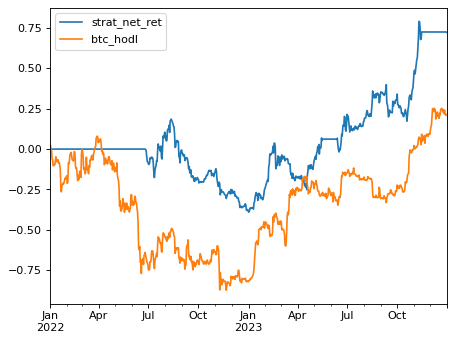

In [19]:
schedule = top_pairs_corr_coint(px_train, 
                                window = 90, 
                                corr_threshold = 0.82, 
                                pvalue_threshold=0.1,
                                max_pairs = 40)

log_rets = np.log(px_train.ffill()).diff()
rets = px_train.ffill().pct_change()

# 1) master portfolio of zeros
port = pd.DataFrame(index=log_rets.index, columns=px_train.columns)

# 2) loop over each rebalance
for i, (reb_date, pairs, count) in schedule.iterrows():
    # find the next-trading-day after rebalance (skip the day you computed the pairs)
    loc = log_rets.index.get_loc(reb_date)
    if loc + 1 >= len(log_rets.index):
        break
    start = log_rets.index[loc + 1]

    # end = day of next rebalance, or last date
    if i < len(schedule) - 1:
        end = schedule['reb_date'].iloc[i + 1]
    else:
        end = log_rets.index[-1]

    # slice the block of returns
    block_rets = log_rets.loc[:end]    

    # recompute β, spread, z over that block
    beta_df, spread_df, z_df, factor = compute_signals(block_rets, pairs, window=90, start = start)

    # build that block’s portfolio
    block_port = generate_portfolio(zscores = z_df, beta = beta_df, factor = factor,
        entry = 0.5,
        exit_z = 1.0)

# 3) assign into the master portfolio
    port.loc[block_port.index, block_port.columns] = block_port.fillna(0)

port = port.ffill()
port = port.loc[insample_start:]
port = np.tanh(port)
port = port.ewm(span = 10, adjust = False).mean()

port[(port > 0).rolling(65).sum() >= 60] = 0
port[(port < 0).rolling(40).sum() >= 35] = 0

port = port.divide(port.abs().sum(1),0).fillna(0)

net_ret, gross_ret, turnover = backtest_with_costs(px_train.loc[insample_start:], port)

print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean()} days")

return_table = pd.DataFrame({
    'strat_gross_ret': calculate_metrics(gross_ret, True),
    'strat_net_ret': calculate_metrics(net_ret, True),
    'btc_hodl': calculate_metrics(rets.loc[insample_start:]['BTCUSDT']),
})

print(return_table)

overall = pd.DataFrame({
    'strat_net_ret': net_ret.loc[insample_start:],
    'btc_hodl': rets.loc[insample_start:]['BTCUSDT']
})

overall.cumsum().plot();

#### Insample Performance
- **Annualized Return:** Net = 36.13% vs BTC = 10.71% → ~3× higher growth.  
- **Volatility:** Net = 40.72% vs BTC = 54.97% → Lower risk than BTC.  
- **Sharpe Ratio:** Net = 0.89 vs BTC = 0.19 → Much better risk-adjusted returns.  
- **Max Drawdown:** Net = -45.30% vs BTC = -66.93% → Smaller peak-to-trough loss.  
- **Drawdown Duration:** 368 days vs BTC 729 days → Faster recovery.  
- **Win Rate:** Net = 53.24% vs BTC = 48.08% → Wins more often than BTC Buy and hold

**Overall:** The strategy delivers **higher returns, better risk-adjusted performance, and shallower, faster-recovering drawdowns** compared to passive BTC holding. But, further out-of-sample testing and robustness checks are essential before deployment.

## Strategy Execution Test Set (Holdout Set)

The average turnover is 0.15409062172547458
The holding period is 12.979375237794605 days
                      strat_gross_ret strat_net_ret     btc_hodl
Cumulative Return             833.60%       674.75%      156.00%
Annualized Return             157.76%       146.52%       68.47%
Annualized Volatility          69.87%        69.81%       49.41%
Sharpe Ratio                 2.258111      2.098652     1.385727
Max Drawdown                  -37.82%       -37.82%      -28.10%
Max Drawdown Duration     159.00 days   159.00 days  237.00 days
Win Rate                       55.79%        54.24%       51.72%
Info Ratio                   2.083149      1.921729          N/A


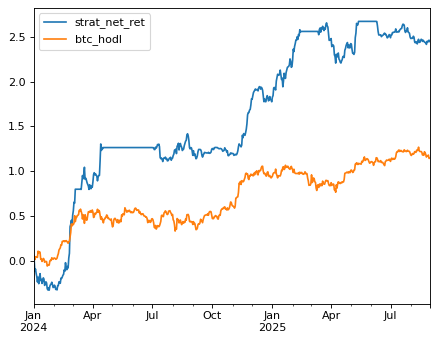

In [20]:
schedule = top_pairs_corr_coint(px, 
                                window = 90, 
                                corr_threshold = 0.82, 
                                pvalue_threshold=0.1,
                                max_pairs = 40)

log_rets = np.log(px.ffill()).diff()

# 1) master portfolio of zeros
port = pd.DataFrame(index=log_rets.index, columns=px.columns)

# 2) loop over each rebalance
for i, (reb_date, pairs, count) in schedule.iterrows():
    # find the next-trading-day after rebalance (skip the day you computed the pairs)
    loc = log_rets.index.get_loc(reb_date)
    if loc + 1 >= len(log_rets.index):
        break
    start = log_rets.index[loc + 1]

    # end = day of next rebalance, or last date
    if i < len(schedule) - 1:
        end = schedule['reb_date'].iloc[i + 1] 
    else:
        end = log_rets.index[-1]

    # slice the block of returns
    block_rets = log_rets.loc[:end]

    # recompute β, spread, z over that block
    beta_df, spread_df, z_df, factor= compute_signals(block_rets, pairs, window=90, start = start)

    # build that block’s portfolio
    block_port = generate_portfolio(zscores = z_df, beta = beta_df, factor = factor,
        entry = 0.5,
        exit_z = 1.0)

    # 3) assign into the master portfolio
    port.loc[block_port.index, block_port.columns] = block_port.fillna(0)


port = port.ffill()
port = port.loc[outsample_start:]
port = np.tanh(port)
port = port.ewm(span = 10, adjust = False).mean()

port[(port > 0).rolling(65).sum() >= 60] = 0
port[(port < 0).rolling(40).sum() >= 35] = 0

port = port.divide(port.abs().sum(1),0).fillna(0)

net_ret, gross_ret, turnover = backtest_with_costs(px[outsample_start:], port)

print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean()} days")

rets = px.ffill().pct_change()
return_table = pd.DataFrame({
    'strat_gross_ret': calculate_metrics(gross_ret, True),
    'strat_net_ret': calculate_metrics(net_ret, True),
    'btc_hodl': calculate_metrics(rets.loc[outsample_start:]['BTCUSDT']),
})

print(return_table)

overall = pd.DataFrame({
    'strat_net_ret': net_ret,
    'btc_hodl': rets.loc[outsample_start:]['BTCUSDT']
})

overall.cumsum().plot();

In [21]:
overall.cumsum().iloc[-1]

strat_net_ret    2.444605
btc_hodl         1.142456
Name: 2025-08-31 00:00:00, dtype: float64

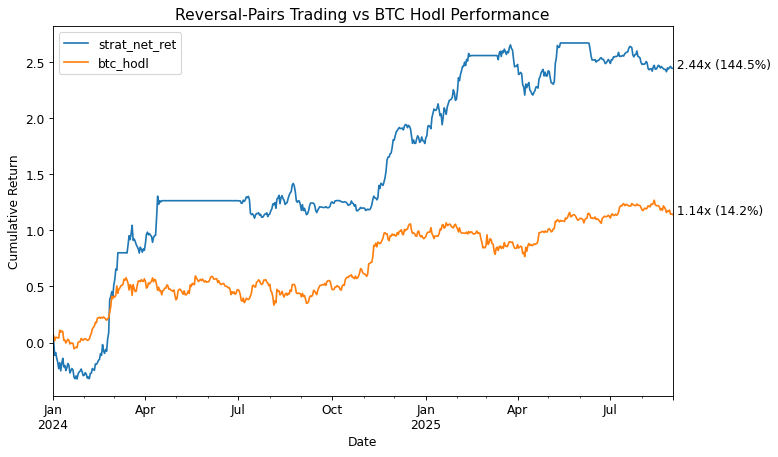

In [22]:
ax = overall.cumsum().plot(title = 'Reversal-Pairs Trading vs BTC Hodl Performance',figsize = (10,6));

ax.set_title("Reversal-Pairs Trading vs BTC Hodl Performance", fontsize=14)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,0], s=' 2.44x (144.5%)', 
        color="black", fontsize=11)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,1], s=' 1.14x (14.2%)', 
        color="black", fontsize=11)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Cumulative Return', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

### Pairs Trading Strategy vs BTC HODL (Holdout Set)

- **Annualized Return:** Net = 146.52% vs BTC = 68.47% →  Double the growth rate.  
- **Annualized Volatility:** Net = 69.81% vs BTC = 49.41% → Higher risk.  
- **Sharpe Ratio:** Net = 2.1 vs BTC = 1.39 → Better risk-adjusted performance.  
- **Max Drawdown:** Net = -37.82% vs BTC = -28.10% → Higher peak-to-trough risk.  
- **Drawdown Duration:** 159 days vs BTC 237 days → Faster recovery.  
- **Win Rate:** Net = 54.24% vs BTC = 51.72% → Wins smore often than BTC

✅ **Overall:** The strategy delivers **higher returns with comparable risk**, and recovers from drawdowns faster than a passive BTC buy and hold.

In [23]:
btc_hodl_ret = rets.loc[outsample_start:]['BTCUSDT']

In [24]:
net_ret.name = 'strat_net_ret'
btc_hodl_ret.name = 'btc_hodl'
df_rets = pd.concat([net_ret, btc_hodl_ret], axis = 1)

strat_net_ret   -0.378246
btc_hodl        -0.280953
dtype: float64


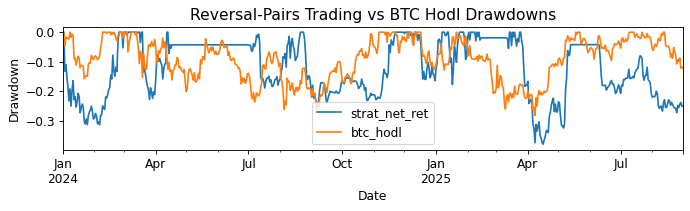

In [25]:
print(drawdown(df_rets).min())
s = drawdown(df_rets)
ax = s.plot( figsize = (10,2), title = "Reversal-Pairs Trading vs BTC Hodl Drawdowns", 
            xlabel = "Date", ylabel = "Drawdown");

ax.set_title("Reversal-Pairs Trading vs BTC Hodl Drawdowns", fontsize=14)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Drawdown', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

Strategy maximum drawdown is -37.8%, higher than benchmark (BTC buy and hold) however, the strategy has shown faster recovery compared to the benchmark

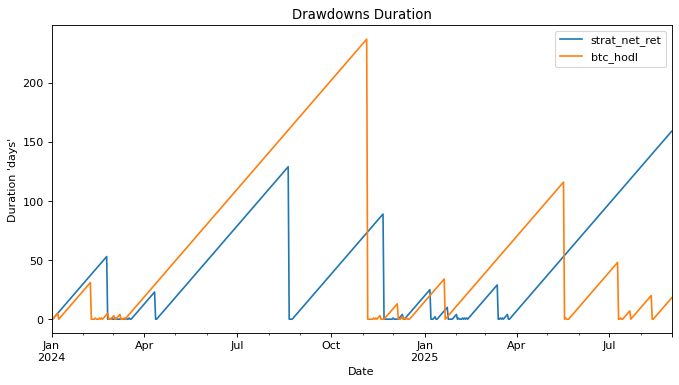

In [26]:
duration(df_rets).plot( figsize = (10,5), title = "Drawdowns Duration", 
                       xlabel = "Date", ylabel = "Duration 'days'");

In [27]:
data = pd.concat([net_ret, btc_hodl_ret], axis=1).dropna()
y = data.iloc[:,0]   # strategy
x = data.iloc[:,1]   # benchmark

# Regression (to get alpha & beta)
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
alpha, beta = model.params
alpha_ann = alpha * 365  # annualized alpha

# Residual Returns
resid_ret = y - beta * x

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          strat_net_ret   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     12.43
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           0.000454
Time:                        09:52:10   Log-Likelihood:                 1157.9
No. Observations:                 609   AIC:                            -2312.
Df Residuals:                     607   BIC:                            -2303.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.474      0.0

In [28]:
print("Alpha (annualized):", alpha_ann)
print("Beta:", beta)

Alpha (annualized): 1.3281097839525813
Beta: 0.2001500805606348


- **Alpha (132.8% annualized)**: The strategy consistently generates excess returns independent of market movements.  
- **Beta (0.20)**: low BTC exposure (a 1% BTC move implies ~0.2% strategy move); it’s partially market-driven but still far from a pure beta

In [29]:
SR = net_ret.mean() / net_ret.std() * np.sqrt(365)
IR = resid_ret.mean() / resid_ret.std() * np.sqrt(365)

print('Strategy Sharpe Ratio is ', SR)
print('Strategy Information Ratio is ', IR)

Strategy Sharpe Ratio is  2.09865244947426
Strategy Information Ratio is  1.9217294587892362


Strategy information ratio is 1.92 which shows consistent and risk efficiency over the benchmark.

At **1.92 IR**, this strategy provides a reliable edge over BTC buy-and-hold

In [30]:
vol = {}
vol['original volatility'] = net_ret.std()*np.sqrt(365)
vol['residual volatility'] = resid_ret.std()*np.sqrt(365)
vol

{'original volatility': 0.6981419073494972,
 'residual volatility': 0.6911013295229086}

In [31]:
print('Strategy return correlation with btc hodl return is ', net_ret.corr(btc_hodl_ret))
print('Strategy residual return correlation with btc hodl return is ', resid_ret.corr(btc_hodl_ret))

Strategy return correlation with btc hodl return is  0.14166076710541622
Strategy residual return correlation with btc hodl return is  1.898364658833837e-16
